### Import Packages

In [1]:
import os
import sys
import json
import inspect
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from scipy.interpolate import make_interp_spline


# Set directories
notebook_dir = os.getcwd()
base_dir = os.path.join(notebook_dir, '..')
data_dir = os.path.join(base_dir, 'data')
src_dir = os.path.join(base_dir, 'src')
graph_dir = os.path.join(base_dir, 'results', 'graphs')
sys.path.append(src_dir)

# Import optimal portfolio
from optimal_portfolios import OptimalPortfolios
warnings.simplefilter(action='ignore', category=FutureWarning)

### Read Data

In [2]:
# Read optimal portfolio weights
with open(os.path.join(data_dir, 'stocks/pfo_weights.json'), 'r') as json_file:
    json_dict = json.load(json_file)
pfo_weights_dict = {key: pd.read_json(json_str) for key, json_str in json_dict.items()}

# Read stock sector
sectors = pd.read_csv(os.path.join(data_dir, 'stock_sector.csv'))

### Group stocks weight by sectors

In [3]:
def weight_by_year_pfo(pfo_weights_dict, year, pfo):
    # Weight by given portoflio and years
    weight_by_sector = pd.merge(pfo_weights_dict[year], sectors, on='tickers', how='inner').groupby(['sector']).sum()
    portfolio_str = 'weight_' + str(pfo)

    # Rename 'Communication Services' to 'Communication'
    weight_by_sector.rename(index={'Communication Services': 'Communication', 'Information Technology': 'Technology'}, inplace=True)

    # Combine 'Consumer Discretionary' and 'Consumer Staples' into 'Consumer'
    weight_by_sector.loc['Consumer'] = weight_by_sector.loc['Consumer Discretionary'] + weight_by_sector.loc['Consumer Staples']
    weight_by_sector.drop(['Consumer Discretionary', 'Consumer Staples'], inplace=True)

    # Transpose and rename column
    weight_by_sector = weight_by_sector[[portfolio_str]].T.rename(index={portfolio_str: year})

    # Drop column names and name index 'Year'
    weight_by_sector.columns.name = None                                                           
    return weight_by_sector

def weight_by_pfo(pfo_weights_dict, pfo):
    # Weight by given portfolio by looping over years
    years = list(pfo_weights_dict.keys())
    for idx, y in enumerate(years):
        if idx == 0:
            weight_by_pfo = weight_by_year_pfo(pfo_weights_dict, y, pfo)
        else:
            weight_by_pfo = pd.concat([weight_by_pfo, weight_by_year_pfo(pfo_weights_dict, y, pfo)])
    return weight_by_pfo


# Find the weight for porfolio 1, 3, 5
pfo_1_weight = weight_by_pfo(pfo_weights_dict, 1)
pfo_3_weight = weight_by_pfo(pfo_weights_dict, 3)
pfo_5_weight = weight_by_pfo(pfo_weights_dict, 5)

### Plot Portfolio Weight by Sector

Plot Portfolio 1

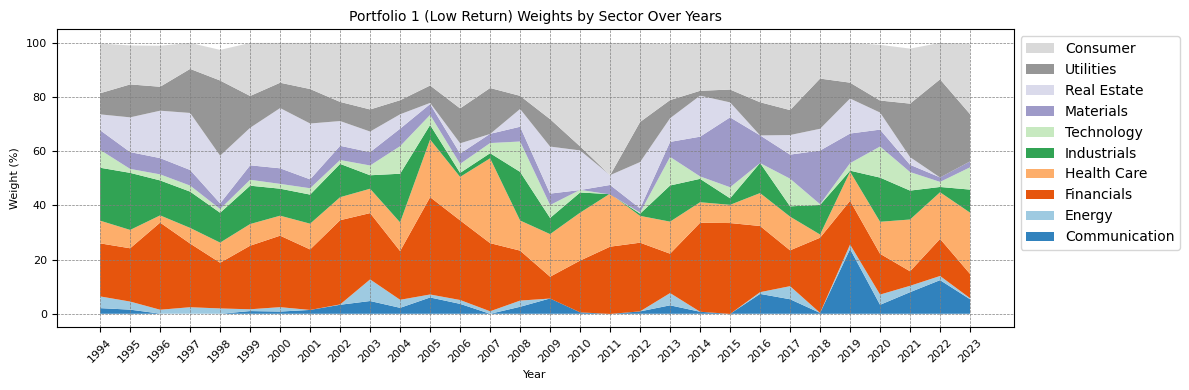

In [6]:
# Use the 'tab20c' colormap for a diverse set of colors
colors = cm.tab20c(np.linspace(0, 1, len(pfo_1_weight.columns)))

# Plot a stacked area chart
plt.figure(figsize=(12, 4))
plt.stackplot(pfo_1_weight.index, [pfo_1_weight[column] * 100 for column in pfo_1_weight.columns], labels=pfo_1_weight.columns, colors=colors)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Portfolio 1 (Low Return) Weights by Sector Over Years', fontsize=10)
plt.xlabel('Year', fontsize=8)
plt.ylabel('Weight (%)', fontsize=8)
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.grid(True, linestyle='--', color='grey', linewidth=0.5)
plt.tight_layout()
# plt.savefig(os.path.join(graph_dir, 'portfolio_weights_chart_1.png'), bbox_inches='tight')
plt.show()

Plot Portfolio 5

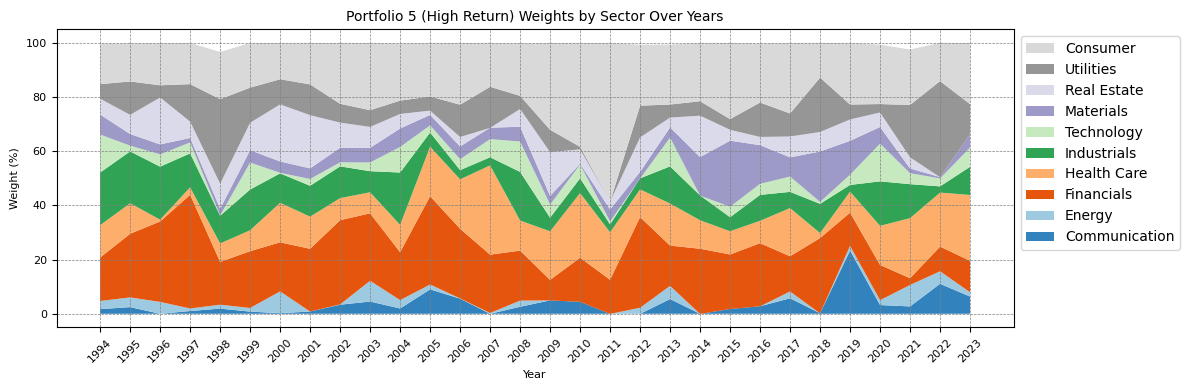

In [8]:
# Use the 'tab20c' colormap for a diverse set of colors
colors = cm.tab20c(np.linspace(0, 1, len(pfo_5_weight.columns)))

# Plot a stacked area chart
plt.figure(figsize=(12, 4))
plt.stackplot(pfo_5_weight.index, [pfo_5_weight[column] * 100 for column in pfo_5_weight.columns], labels=pfo_5_weight.columns, colors=colors)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Portfolio 5 (High Return) Weights by Sector Over Years', fontsize=10)
plt.xlabel('Year', fontsize=8)
plt.ylabel('Weight (%)', fontsize=8)
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.grid(True, linestyle='--', color='grey', linewidth=0.5)
plt.tight_layout()
# plt.savefig(os.path.join(graph_dir, 'portfolio_weights_chart_5.png'), bbox_inches='tight')
plt.show()